## Introduction

In this question, you'll build a classifier on one of the classical machine learning datasets, the MNIST digit classification task. While this is a bit of a departure from the material in most of this course (MNIST definitely counts as a _highly_ curated data set at this point, and solutions that are much more accurate than what we'll perform here are widely available, the purpose of this question is two-fold:
1. Become familiar with multi-class classification, which wasn't covered in lecture, but which is a relatively simple extension of binary classification.
2. Get at least a little bit familiar with the MNIST data, which is a very standard data set in machine learning, after all.

## Multiclass classification

Multiclass classification is the task of predicting some discrete-valued output
$$y^{(i)} \in \{1,2,\ldots,k\}.$$
To accomplish this task, we're going to expand our notion of a hypothesis function a bit.  Instead of having a scalar-valued hypothesis function (e.g., for binary classification, where it determines the confidence level in our prediction), in multi-class classification we have a _vector valued_ hypothesis function
$$h_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^k$$
i.e. $h_\theta(x)$ is a _vector_, where each entry correponds to a confidence measure for each of the $k$ classes.  These $k$ different numbers (informally speaking) represent the _relative_ confidence we have for each class, so that if $k=3$, and our hypothesis function outputs
$$h_\theta(x) = \left [ \begin{array}{c} 1.0 \\ -0.4 \\ 2.0 \end{array} \right ]$$
this corresponds to a situation where we believe the most likely class to be $3$, followed by $1$, and then $2$.  If we need to make a single prediction, we simply predict the class with the largest hypothesis value.  Fortunately, everything else remains pretty similar as with normal classification, we just need to specify the three ingredients of any machine learning algorithm
1. The hypothesis class
2. The loss function
3. The optimization appoach

#### Hypothesis class
The hypothesis class that we will use for multiclass classification is still a linear hypothesis function, that is
$$h_\theta(x) = \theta^T x$$
except that here, in order to produce an output of the correct size, we need to consider $\theta$ to be a _matrix_ $\theta \in \mathbb{R}^{n \times k}$.  This will effect our updates (i.e., the gradients themselves must be matrices now instead of vectors).  When needed, we will refer to the $j$th _column_ of $\theta$ by $\theta_j$.  

#### Loss function
The loss function we will use here is called the _softmax_ (or sometimes _cross-entropy_ loss), which is actually a generalization of the logistic loss to the multiclass setting.  Rembmer that the loss function is defined as a function measuring the difference between the results the hypothesis function and the actual outputs.

Softmax loss, like logistic loss, has an interpretation as a log probability function.  Specifically, given our output $\hat{y} = h_\theta(x)$, we suppose that the probability of each class is given by a distribution propotional to the _exponential_ of the hypothesis function
$$ p(y = i|x;\theta) = \frac{\exp(\hat{y}_i)}{\sum_{j=1}^p \exp(\hat{y}_j)}  = \frac{\exp(\theta_i^T x)}{\sum_{j=1}^k \exp(\theta_j^T x)} $$

Now we consider the maximum likelihood estimation of the parameters, which involves maximizing the log likelihood:
$$\sum_{i=1}^n \log p(y = y^{(i)} | x^{(i)}; \theta) = \sum_{i=1}^m \left ( \theta_{y^{(i)}}^T x - \log \sum_{j=1}^k \exp(\theta_j^T x) \right ). $$
Our loss can then be viewed as the negation of this quantity:
$$\ell(h_\theta(x), y) = -(h_\theta(x))_y + \log \sum_{i=1}^k \exp (h_\theta(x))_j$$

#### Optimization
We're going to optimize just like we did for the other problems, by gradient descent.  The only difference is that this gradient is now a matrix, instead of a vector, and is given by
$$
\nabla_\theta f(\theta) \in \mathbb{R}^{n \times k} = \left [ \begin{array}{ccc} 
\frac{\partial f}{\partial \theta_{11}} & \cdots & \frac{\partial f}{\partial \theta_{1k}} \\
\vdots & \ddots & \vdots \\
\frac{\partial f}{\partial \theta_{n1}} & \cdots & \frac{\partial f}{\partial \theta_{nk}}
\end{array} \right ].
$$
Fortunately, virtually all the same rules apply for gradients that are matrices, and you can always derive these by falling back on the gradient rules, and deriving the gradient for each column in the matrix.



## Q0: MNIST data

To start off, let's load the MNIST data.  The data is included with this notebook, and contains 60,000 28x28 pixel images of digits.  It also contains 10,000 images used as the test set (it's really a holdout set, but since everyone calls it the test set, we'll adopt that notation here).

The following functions below will load the MNIST data.  Loading the data takes a little while (about 30 seconds on a MacBook Pro).

In [3]:
# AUTOLAB_IGNORE_START
X_train = parse_images("train-images-idx3-ubyte")
y_train = parse_labels("train-labels-idx1-ubyte")
X_test = parse_images("t10k-images-idx3-ubyte")
y_test = parse_labels("t10k-labels-idx1-ubyte")
# AUTOLAB_IGNORE_STOP

In [4]:
import numpy as np
import struct

def parse_images(filename):
    f = open(filename,"rb");
    magic,size = struct.unpack('>ii', f.read(8))
    sx,sy = struct.unpack('>ii', f.read(8))
    X = []
    for i in range(size):
        im =  struct.unpack('B'*(sx*sy), f.read(sx*sy))
        X.append([float(x)/255.0 for x in im]);
    return np.array(X);

def parse_labels(filename):
    f = open(filename,"rb");
    magic,size = struct.unpack('>ii', f.read(8))
    return np.array(struct.unpack('B'*size, f.read(size)))

After loading the images, we can path a few examples.  The following code plots a subset of these images, so you can verify that you are in fact reading the problem data correctly.

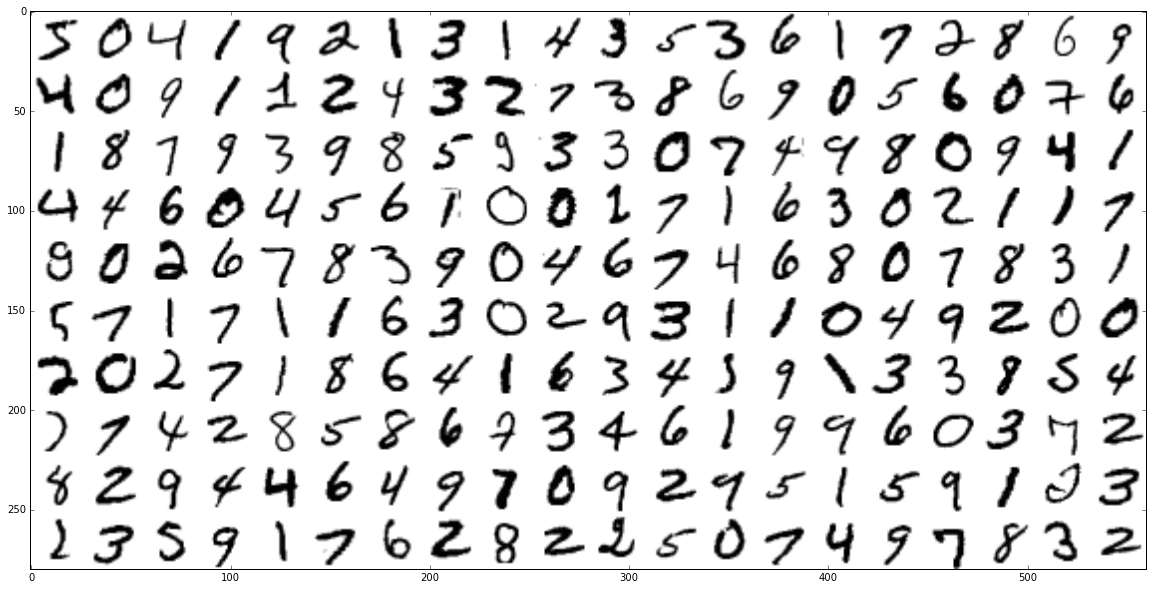

In [5]:
# AUTOLAB_IGNORE_START
import matplotlib.pyplot as plt
%matplotlib inline

M,N = 10,20
fig, ax = plt.subplots(figsize=(N,M))
digits = np.vstack([np.hstack([np.reshape(X_train[i*N+j,:],(28,28)) 
                               for j in range(N)]) for i in range(M)])
ax.imshow(255-digits, cmap=plt.get_cmap('gray'))
# AUTOLAB_IGNORE_STOP

## Softmax loss and gradient (10pts)

For this question, you'll want to derive and implement the softmax loss function and it's gradient.  There are a number of derivations of softmax regression available online, and you can look for one of these if you absolutely must, but if you have some basic familiarity with scalar-valued calculus _and_ use the two gradient rules from the course lecture slides, then you actually have everything you need to derive these gradients, so we recommend that you spend at least a little time trying to do so.  The final functional form of the gradients are quite simple (just a few lines of code).

Hint: try to turn as many of the operations into matrix operators as possible.  For example, although you could compute the hypothesis function for each sample individually, it is _much_ faster to simply use $X \theta$ as a matrix of _all_ predictions (where each row corresponds to the output of the hypothesis function for that example).  Look for tricks like this to make your code much faster.

Make sure that you return the _average_ loss (total loss divided by number of examples), and that you generate the gradient of this average loss.

In [6]:
import scipy.sparse as sp
def softmax_loss(X, Theta, y, return_grad=False):
    """
    Compute softmax loss and its gradient.

    Args:
        X : 2D numpy array, size m x n: array of all input features for all examples
        Theta: 2D numpy array, size n x p: parameter matrix
        y: 1D numpy array, size m: containing indices of correct outputs (zero-indexed)
        return_grad: boolean, whether or not to return gradients
    
    Returns: loss, or (loss, gradient) if return_grad = 0
        loss: the average softmax loss over all examples
        gradient: gradient w.r.t. theta of average loss 
    """
    m = X.shape[0] #Num 
    k = np.amax(y) + 1 #Get max y value 
    y_mat = np.eye(k)[y,:] #One hot y
    
    w = Theta #Set weights as theta
    s = X.dot(w) #Get raw scores
    
    s -= np.max(s)
    z = s
    
    # Matrix Operations below were informed by https://awjuliani.wordpress.com/2016/02/22/simple-softmax-regression-in-python%E2%80%8A-%E2%80%8Atutorial/
    sm = (np.exp(z).T / np.sum(np.exp(s),axis = 1))
    prob = sm.T    
    avg_loss = -np.sum(y_mat * np.log(prob))/float(m)
    grad = ((-1 / m) * X.T.dot(y_mat - prob))/float(m)
        
    if return_grad == True:
        return (avg_loss,grad)
    else: return avg_loss


Evaluating the softmax loss on `X_train` and `y_train` with `Theta` all zeros should return the following loss and gradient (just showing the norm of the gradient, as the entire gradient is too long to display).

In [7]:
### AUTOLAB_IGNORE_START
loss, G = softmax_loss(X_train,np.zeros((X_train.shape[1], np.max(y_train)+1)), y_train, return_grad=True)
print loss, type(G), G.shape, np.linalg.norm(G)
### AUTOLAB_IGNORE_STOP

2.30258509299 <type 'numpy.ndarray'> (784L, 10L) 1.04079351774


In our implementation, this returns the output:
    
    2.30258509299 <type 'numpy.ndarray'> (784, 10) 1.04079351774

## Q2: Gradient descent (15pts)

Now that you have a function to compute the gradient, it should be fairly simple to implement a gradient descent function.  Implement the following radient descent function, which should print information as it runs (this information is only to help you debug, it is not specifically graded by to the autograder).  Specifically, ever 10 iterations should function should print the iteration count, the training and testing error, and the training and testing loss.




    

In [34]:
def softmax_gd(X, y, X_test, y_test, lam=1e-5, alpha=1.0, iters=101):
    """
    Gradient descent to minimize softmax loss.
    
    Args:
        X : 2D numpy array, size m x n, array of all input features for all trainingexamples
        y: 1D numpy array, size m, contains indices of correct outputs on training set (zero-indexed)
        X_test : 2D numpy array, size m0 x n, array of all input features for all testing examples
        y_test: 1D numpy array, size m0, contains indices of correct outputs on testing set (zero-indexed)
        lam: regularization parameter
        alpha: step size
        iters: number of iterations of gradient descent
    
    Returns: Theta
        Theta: matrix of parameters for softmax model
    """
    theta = np.zeros((X.shape[1], np.max(y)+1))
    for i in range(iters):
        loss, grad = softmax_loss(X,theta,y, return_grad = True)
        theta -= alpha * (grad + lam*theta)
        #if (i % 10) == 0: print loss
    return theta
    

Running this code on the raw inputs loaded by MNIST (this is a linear classifier over pixel images), given an error of about 9% on our evaluation. Spcefically, the code:

In [35]:
### AUTOLAB_IGNORE_START
Theta = softmax_gd(X_train, y_train, X_test, y_test)
print type(Theta), Theta.shape, np.linalg.norm(Theta)
### AUTOLAB_IGNORE_STOP

<type 'numpy.ndarray'> (784L, 10L) 7.26895001058


printed the output:

    Iter |Train Err |Test Err  |Train Loss|Test Loss 
        0|    0.9013|    0.9020|    2.3026|    2.3026
       10|    0.2568|    0.2583|    0.9781|    0.9731
       20|    0.1786|    0.1727|    0.5733|    0.5537
       30|    0.1184|    0.1110|    0.4334|    0.4113
       40|    0.1117|    0.1035|    0.4066|    0.3852
       50|    0.1070|    0.1004|    0.3908|    0.3706
       60|    0.1044|    0.0967|    0.3790|    0.3598
       70|    0.1020|    0.0951|    0.3696|    0.3513
       80|    0.0998|    0.0943|    0.3620|    0.3444
       90|    0.0983|    0.0925|    0.3555|    0.3386
      100|    0.0968|    0.0914|    0.3501|    0.3338 
      
and then printed the information from the `print` function:

      <type 'numpy.ndarray'> (784, 10) 7.26895001058

## Q3: Taking it further

This next part is optional, but may be of interest for those who want to explore machine learning techniques more generally.  The basic question is: how well can you do on this dataset with a linear hypothesis function?  We're not going to make this an official contest, as a bunch of example tutorials on MNIST abound, but it's a useful thing to try yourself.

Note that in this particular domain, RBF features are a bit trickier to get to work (they _can_ work, they just need a bit more tweaking than usual).  Instead, in this problem we had better luck with polynomial features.  However, since we couldn't enumberate polynomials over the input, we selected a random set of features in proportion to the standard deviation of the corresponding pixel (i.e., higher standard deviation means the pixel varies more, which may be useful for inferring any connections between it and the output).


In [26]:
### AUTOLAB_IGNORE_START
from itertools import combinations_with_replacement
import operator
def poly(X,d):
    return np.array([reduce(operator.mul, a, np.ones(X.shape[0])) 
                     for a in combinations_with_replacement(X.T, d)]).T

stds = np.std(X_train, axis=0)
stds /= np.sum(stds)
np.random.seed(0)
idx = np.where(np.random.multinomial(50,stds))[0]

X_train0 = np.hstack([poly(X_train[:,idx],2), X_train, np.ones((X_train.shape[0], 1))])
X_test0 = np.hstack([poly(X_test[:,idx],2), X_test, np.ones((X_test.shape[0], 1))])

meanX = np.mean(X_train0, axis=0)
stdX = np.std(X_train0, axis=0)
X_train0 = (X_train0[:,stdX>1e-6] - meanX[stdX>1e-6])/stdX[stdX>1e-6]
X_test0 = (X_test0[:,stdX>1e-6] - meanX[stdX>1e-6])/stdX[stdX>1e-6]


In [27]:
softmax_gd(X_train0, y_train, X_test0, y_test)
### AUTOLAB_IGNORE_STOP

2.30258509299
0.490890844294
0.222600912514


KeyboardInterrupt: 

This produces the following output (getting a 4.5\% test error, which is fairly reasonable for an algorithm only working with features generated automatically from raw input).

    Iter |Train Err |Test Err  |Train Loss|Test Loss 
        0|    0.9013|    0.9020|    2.3026|    2.3026
       10|    0.1179|    0.1152|    0.4909|    0.4933
       20|    0.0619|    0.0641|    0.2226|    0.2391
       30|    0.0530|    0.0566|    0.1860|    0.2052
       40|    0.0479|    0.0530|    0.1692|    0.1898
       50|    0.0446|    0.0503|    0.1585|    0.1808
       60|    0.0422|    0.0485|    0.1506|    0.1747
       70|    0.0402|    0.0477|    0.1444|    0.1703
       80|    0.0386|    0.0463|    0.1391|    0.1669
       90|    0.0373|    0.0452|    0.1347|    0.1642